# Demo: Proposed (*M-CUR) on `gray_carvid.mat` and `gray_escalator.mat`

This notebook reproduces the implementation of the proposed tensor *M-CUR

**Data format:** `.mat` contains a single 3D array with shape `(m, n, p)` = (height, width, frames).

**Authors:** Susana Lopez-Moreno, June-Ho Lee, Taehyeong Kim.

In [16]:
from __future__ import annotations

import time
from pathlib import Path
from typing import Iterable, Sequence

import numpy as np
from numpy.typing import ArrayLike
import scipy.io as sio
import scipy.linalg as la
import scipy.sparse.linalg as spla

import matplotlib.pyplot as plt
import cv2
import imageio.v2 as imageio

np.random.seed(0)

# Data processing

In [17]:
def covt(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X, dtype=np.float64)
    xmin = np.min(X)
    xmax = np.max(X)
    if xmax > xmin:
        Y = (X - xmin) / (xmax - xmin)
    else:
        Y = np.zeros_like(X)
    Y = np.clip(Y, 0.0, 1.0)
    return (255.0 * Y).round().astype(np.uint8)

# *M CUR

Helper functions

In [18]:
_MAD_NORM = 0.6744898

def dctmtx(n: int) -> np.ndarray:
    from scipy.fftpack import dct
    I = np.eye(n)
    return dct(I, type=2, norm='ortho', axis=0)

def soft_th_mad(R: np.ndarray, tau: float) -> np.ndarray:
    R = np.asarray(R, dtype=np.float64)
    if R.ndim != 3:
        raise ValueError("R must be a 3D tensor (m,n,p)")
    m, n, p = R.shape
    S = np.zeros_like(R)
    eps = np.finfo(float).eps
    for k in range(p):
        X = R[:, :, k]
        med = np.median(X)
        sigma = np.median(np.abs(X - med)) / _MAD_NORM
        th = tau * max(sigma, eps)
        S[:, :, k] = np.sign(X) * np.maximum(np.abs(X) - th, 0.0)
    return S

def foreground_from_mask(S_fg: np.ndarray, D: np.ndarray, tau: float):
    S_fg = np.asarray(S_fg, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    if S_fg.shape != D.shape:
        raise ValueError("S_fg and D must have the same shape")

    m, n, p = S_fg.shape
    F_masked = np.zeros_like(D)
    M = np.zeros((m, n, p), dtype=bool)
    eps = np.finfo(float).eps

    for k in range(p):
        X = S_fg[:, :, k]
        med = np.median(X)
        sigma = np.median(np.abs(X - med)) / _MAD_NORM
        th = tau * max(sigma, eps)
        Mk = np.abs(X) >= th
        M[:, :, k] = Mk
        F_masked[:, :, k] = D[:, :, k] * Mk.astype(np.float64)

    return F_masked, M

def _top_singular_vectors(Y: np.ndarray, r: int):
    m, n = Y.shape
    r_use = max(1, min(r, m, n))
    if r_use == 1:
        # svds is sometimes finicky for k=1; handle with fallback
        try:
            u, s, vt = spla.svds(Y, k=1, which='LM')
            # svds returns ascending singular values; for k=1 it's fine
            idx = np.argsort(s)[::-1]
            u = u[:, idx]
            vt = vt[idx, :]
            return u, vt.T
        except Exception:
            pass

    try:
        # use svds to get r_use largest singular vectors
        u, s, vt = spla.svds(Y, k=r_use, which='LM')
        idx = np.argsort(s)[::-1]
        u = u[:, idx]
        vt = vt[idx, :]
        return u, vt.T
    except Exception:
        U, s, Vt = la.svd(Y, full_matrices=False)
        U = U[:, :r_use]
        V = Vt[:r_use, :].T
        return U, V

def select_IJ_by_DEIM_band(Yt: np.ndarray, r_sub: int, r_rows: int, c_cols: int, K: int):
    Yt = np.asarray(Yt, dtype=np.float64)
    if Yt.ndim != 3:
        raise ValueError("Yt must be a 3D tensor (m,n,p)")
    m, n, p = Yt.shape
    K = int(min(K, p))
    Uall = []
    Vall = []

    for k in range(K):
        Yk = Yt[:, :, k]
        Uk, Vk = _top_singular_vectors(Yk, r_sub)
        Uall.append(Uk)
        Vall.append(Vk)

    Uall = np.concatenate(Uall, axis=1) if Uall else np.zeros((m, 0))
    Vall = np.concatenate(Vall, axis=1) if Vall else np.zeros((n, 0))

    # Economy QR (no pivoting)
    QU, _ = np.linalg.qr(Uall, mode='reduced')
    QV, _ = np.linalg.qr(Vall, mode='reduced')

    sI = int(min(r_rows, QU.shape[1]))
    sJ = int(min(c_cols, QV.shape[1]))

    # Pivoted QR on transpose: columns correspond to original rows/cols
    if sI > 0:
        _, _, pivU = la.qr(QU.T, pivoting=True, mode='economic')
        I = np.sort(pivU[:sI])
    else:
        I = np.array([], dtype=int)

    if sJ > 0:
        _, _, pivV = la.qr(QV.T, pivoting=True, mode='economic')
        J = np.sort(pivV[:sJ])
    else:
        J = np.array([], dtype=int)

    return I, J

def project_CUR_band(Yt: np.ndarray, I: np.ndarray, J: np.ndarray, K: int, lambda_ridge: float, pinv_tol: float):
    Yt = np.asarray(Yt, dtype=np.float64)
    m, n, p = Yt.shape
    K = int(min(K, p))
    Lt = np.zeros_like(Yt)

    I = np.asarray(I, dtype=int)
    J = np.asarray(J, dtype=int)
    if I.size == 0 or J.size == 0:
        return Lt

    for k in range(K):
        Yk = Yt[:, :, k]
        Ck = Yk[:, J]    # (m, |J|)
        Rk = Yk[I, :]    # (|I|, n)
        Wk = Yk[np.ix_(I, J)]  # (|I|, |J|)

        if lambda_ridge > 0:
            # Uk = (Wk'Wk + λI)^{-1} Wk'
            G = Wk.T @ Wk + lambda_ridge * np.eye(Wk.shape[1])
            Uk = la.solve(G, Wk.T, assume_a='pos', overwrite_a=False, overwrite_b=False)
        else:
            Uk = la.pinv(Wk, rcond=pinv_tol)

        Lt[:, :, k] = Ck @ (Uk @ Rk)

    return Lt

def mode_unfold(A: np.ndarray, k: int | None = None) -> np.ndarray:
    if k is None:
        k = A.ndim - 1
    if not (0 <= k < A.ndim):
        raise ValueError(f"k must be in [0, {A.ndim-1}], got {k}")

    idx = (k,) + tuple(range(0, k)) + tuple(range(k + 1, A.ndim))
    Ap = np.transpose(A, idx)
    return Ap.reshape((A.shape[k], -1), order='F')

def mode_fold(Ak: np.ndarray, shape: tuple[int, ...], k: int | None = None) -> np.ndarray:
    if k is None:
        k = len(shape) - 1
    if not (0 <= k < len(shape)):
        raise ValueError(f"k must be in [0, {len(shape)-1}], got {k}")

    idx = (k,) + tuple(range(0, k)) + tuple(range(k + 1, len(shape)))
    reshaped = Ak.reshape(tuple(shape[i] for i in idx), order='F')

    # undo permutation
    inv_idx = tuple(range(1, k + 1)) + (0,) + tuple(range(k + 1, len(shape)))
    return np.transpose(reshaped, inv_idx)

def mode_k_mul(A: np.ndarray, M: np.ndarray, k: int) -> np.ndarray:
    if A.ndim < k + 1:
        raise ValueError(f"A.ndim={A.ndim} but k={k}")
    if M.shape[1] != A.shape[k]:
        raise ValueError(f"M.shape[1]={M.shape[1]} must match A.shape[k]={A.shape[k]}")
    out_shape = list(A.shape)
    out_shape[k] = M.shape[0]

    Ak = mode_unfold(A, k)
    Bk = M @ Ak
    return mode_fold(Bk, tuple(out_shape), k)

def mode3mul(Y: np.ndarray, M: np.ndarray) -> np.ndarray:
    if Y.ndim != 3:
        raise ValueError("mode3mul expects a 3D tensor (m,n,p)")
    return mode_k_mul(Y, M, k=2)


In [19]:
def run_mcur(
    D: np.ndarray,
    r_sub: int = 10,
    K_low: int = 20,
    row_frac: float = 0.6,
    col_frac: float = 0.6,
    Titer: int = 6,
    tau_mad: float = 0.5,
    tau_fg_mask: float = 7.5,
    lambda_ridge: float = 1e-2,
    pinv_tol: float = 1e-6,
    refresh_every: int = 1,
    rng: np.random.Generator | None = None,
    verbose: bool = True,
):
    """Run the proposed (*M-CUR) algorithm.

    Returns: L_bg, S_fg, F_masked, mask, debug
    """

    D = np.asarray(D, dtype=np.float64)
    if D.ndim != 3:
        raise ValueError("D must be a 3D tensor (m,n,p)")

    mD, nD, pD = D.shape
    B0p = np.median(D, axis=2)
    D0 = D - B0p[:, :, None]

    M_full = dctmtx(pD)
    r_eff = pD
    M = M_full[:r_eff, :]
    Minv = M_full[:, :r_eff]

    L_prop = np.zeros_like(D0)
    S_prop = np.zeros_like(D0)

    I_det = None
    J_det = None
    r_rows = max(20, min(mD, int(round(row_frac * mD))))
    c_cols = max(20, min(nD, int(round(col_frac * nD))))

    for t in range(1, Titer + 1):
        R = D0 - L_prop
        S_prop = soft_th_mad(R, tau_mad)

        Y = D0 - S_prop
        Yt = mode3mul(Y, M)
        K_use = min(K_low, Yt.shape[2])

        if (I_det is None) or (J_det is None) or ((t - 1) % refresh_every == 0):
            I_det, J_det = select_IJ_by_DEIM_band(Yt, r_sub, r_rows, c_cols, K_use)
            if verbose:
                print(f"  DEIM selection (iter {t}): |I|={I_det.size}, |J|={J_det.size}")

        Lt = project_CUR_band(Yt, I_det, J_det, K_use, lambda_ridge, pinv_tol)
        L_prop = mode3mul(Lt, Minv)

        relres = np.linalg.norm((D0 - L_prop - S_prop).ravel()) / max(np.linalg.norm(D0.ravel()), np.finfo(float).eps)
        if verbose:
            print(f"  iter {t}/{Titer}  rel-res={relres:.3e}")

    L_bg = L_prop + B0p[:, :, None]
    S_fg = D - L_bg
    F_masked, mask = foreground_from_mask(S_fg, D, tau_fg_mask)

    debug = dict(B0p=B0p, D0=D0, L_prop=L_prop, S_prop=S_prop, M=M, Minv=Minv, I_det=I_det, J_det=J_det)

    return L_bg, S_fg, F_masked, mask, debug

# Demo

In [20]:
plt.rcParams.update({
    "figure.dpi": 120,
    "savefig.dpi": 200,
})

In [21]:
# -----------------------
# Config
# -----------------------
DATA_PATHS = [
    "gray_escalator.mat",
    "gray_carvid.mat",
]
FRAME_TO_SHOW = 60   # 1-based frame index (will be clamped per dataset)


In [22]:
def load_mat_3d(path: str | Path) -> np.ndarray:
    path = Path(path)
    mat = sio.loadmat(path)
    keys = [k for k in mat.keys() if not k.startswith("__")]
    if not keys:
        raise ValueError(f"No array variable found in {path}")
    arr = mat[keys[0]]
    if arr.ndim != 3:
        raise ValueError(f"Expected 3D array in {path}, got shape {arr.shape}")
    return arr.astype(np.float64)

def clamp_frame_idx(fm_1based: int, p: int) -> tuple[int, int]:
    fm = max(1, min(int(fm_1based), p))
    k = fm - 1
    return fm, k

def pretty_time(s: float | None) -> str:
    if s is None:
        return "—"
    return f"{s:.3f}s"

In [23]:
results = []  # list of dicts: {name, vid, k, fm, p}

for data_path in DATA_PATHS:
    vid = load_mat_3d(data_path) / 255.0
    m0, n0, p0 = vid.shape
    fm, k = clamp_frame_idx(FRAME_TO_SHOW, p0)

    print(f"Loaded {data_path}: [{m0} x {n0} x {p0}]  (m,n,p)")
    print(f"  Displaying frame: {fm} (0-based index {k})")

    results.append({
        "name": Path(data_path).stem,
        "path": data_path,
        "vid": vid,
        "p": p0,
        "fm": fm,
        "k": k,
    })


Loaded gray_escalator.mat: [130 x 160 x 200]  (m,n,p)
  Displaying frame: 60 (0-based index 59)
Loaded gray_carvid.mat: [120 x 160 x 120]  (m,n,p)
  Displaying frame: 60 (0-based index 59)


In [24]:
for r in results:
    print(f"=== Running Proposed (*M-CUR) on {r['path']} ===")
    t0 = time.time()
    L_bg_prop, S_fg_prop, F_masked_prop, _, _ = run_mcur(
        r["vid"],
        r_sub=10,
        K_low=20,
        row_frac=0.6,
        col_frac=0.6,
        Titer=6,
        tau_mad=0.5,
        tau_fg_mask=7.5,
        lambda_ridge=1e-2,
        pinv_tol=1e-6,
        refresh_every=1,
        verbose=True,
    )
    r["L_bg_prop"] = L_bg_prop
    r["S_fg_prop"] = S_fg_prop
    r["F_masked_prop"] = F_masked_prop
    r["t_prop"] = time.time() - t0
    print(f"  Proposed done in {r['t_prop']:.3f} sec.\n")


=== Running Proposed (*M-CUR) on gray_escalator.mat ===
  DEIM selection (iter 1): |I|=78, |J|=96
  iter 1/6  rel-res=1.119e-01
  DEIM selection (iter 2): |I|=78, |J|=96
  iter 2/6  rel-res=1.167e-01
  DEIM selection (iter 3): |I|=78, |J|=96
  iter 3/6  rel-res=1.214e-01
  DEIM selection (iter 4): |I|=78, |J|=96
  iter 4/6  rel-res=1.247e-01
  DEIM selection (iter 5): |I|=78, |J|=96
  iter 5/6  rel-res=1.257e-01
  DEIM selection (iter 6): |I|=78, |J|=96
  iter 6/6  rel-res=1.274e-01
  Proposed done in 4.728 sec.

=== Running Proposed (*M-CUR) on gray_carvid.mat ===
  DEIM selection (iter 1): |I|=72, |J|=96
  iter 1/6  rel-res=3.060e-02
  DEIM selection (iter 2): |I|=72, |J|=96
  iter 2/6  rel-res=3.836e-02
  DEIM selection (iter 3): |I|=72, |J|=96
  iter 3/6  rel-res=4.352e-02
  DEIM selection (iter 4): |I|=72, |J|=96
  iter 4/6  rel-res=4.561e-02
  DEIM selection (iter 5): |I|=72, |J|=96
  iter 5/6  rel-res=4.574e-02
  DEIM selection (iter 6): |I|=72, |J|=96
  iter 6/6  rel-res=4.525e

In [27]:
def show(ax, img, title):
    ax.imshow(covt(img), cmap="gray", vmin=0, vmax=255)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

def plot_mcur_3datasets(results, frame_to_show_1based: int = 60):
    if len(results) != 2:
        raise ValueError(f"Expected exactly 2 datasets, got {len(results)}")

    fig, axes = plt.subplots(3, 2, figsize=(12, 9))
    fig.suptitle(f"*M-CUR Foreground/Background (frame {frame_to_show_1based})", fontsize=14)

    for j, r in enumerate(results):
        name = r.get("name", f"dataset{j+1}")
        k = r["k"]

        # Row 1: original
        show(axes[0, j], r["vid"][:, :, k], f"{name}\nOriginal")

        # Row 2: background
        show(axes[1, j], r["L_bg_prop"][:, :, k], "Background")

        # Row 3: foreground (masked)
        show(axes[2, j], r["F_masked_prop"][:, :, k], "Foreground")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return


# Plot

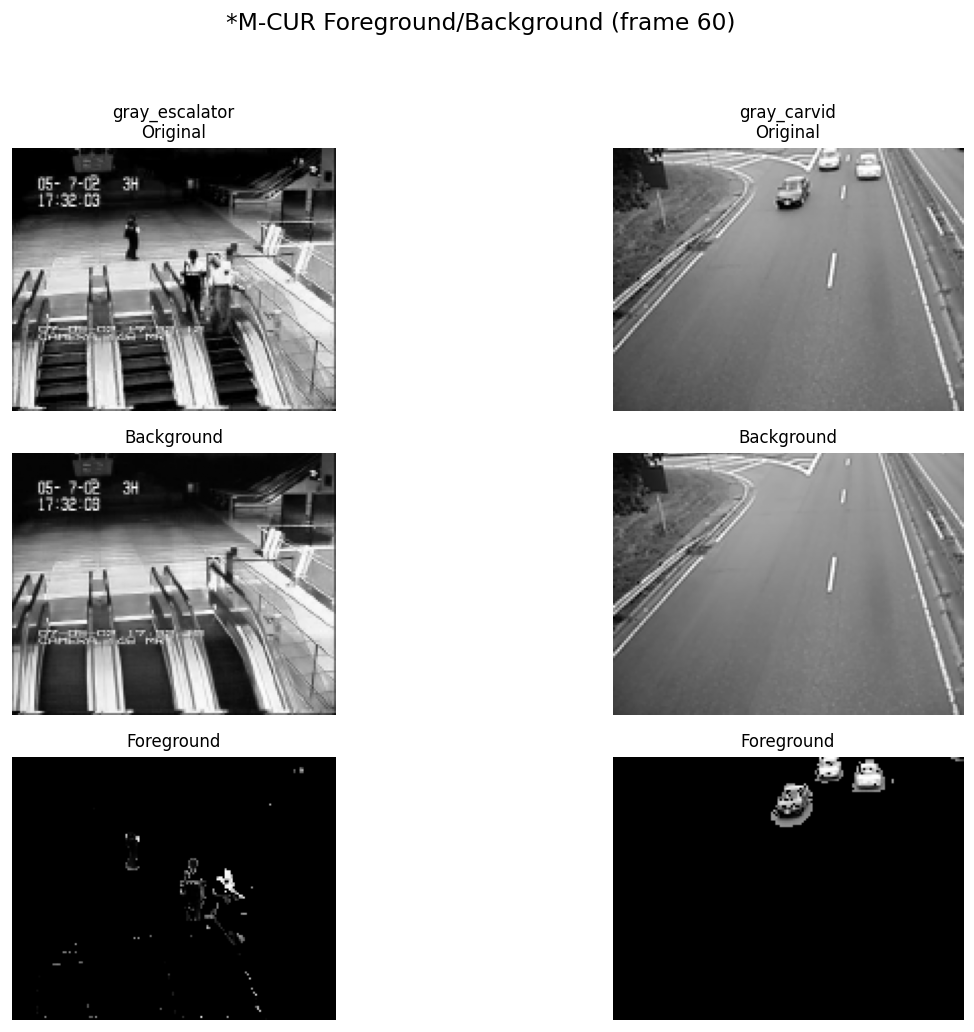

In [28]:
plot_mcur_3datasets(results, frame_to_show_1based=FRAME_TO_SHOW)


In [29]:
import pandas as pd

df = pd.DataFrame([
    {"Dataset": r["name"], "Path": r["path"], "Frames(p)": r["p"], "Frame shown": r["fm"], "Proposed time (s)": r["t_prop"]}
    for r in results
])

df


,Dataset,Path,Frames(p),Frame shown,Proposed time (s)
0,gray_escalator,gray_escalator.mat,200,60,4.728485
1,gray_carvid,gray_carvid.mat,120,60,3.382173
